# SecureReqNet Embeddings
Generates embeddings used to train SecureReqNet models.

In [ ]:
#danaderp March 2018
#Generates the embeddings used to train securereqnet models

In [ ]:
import csv
#Implementing the Skip-Gram Model
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [ ]:
from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

In [ ]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [ ]:
#Preprocessing Part O
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
remove_terms = punctuation + '0123456789'

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    #Filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    #Filtering Stemmings
    filtered_tokens = [englishStemmer.stem(token) for token in filtered_tokens]
    #Filtering remove-terms
    filtered_tokens = [token for token in filtered_tokens if token not in remove_terms and len(token)>2]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [ ]:
#Preprocessing Part I
remove_terms

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [ ]:
#Extracting Data
filename = 'cve_dataset.tsv'
data = []
with open(filename, 'r') as tsv_file:
	tsv_reader = csv.reader(tsv_file, delimiter='\t')
	for line in tsv_reader:
		data.append((line[1], line[2]))

for d in data:
	print(d)


('10.0', 'A buffer overflow in InterScan VirusWall 3.23 and 3.3 allows a remote attacker to execute arbitrary code by sending a long HELO command to the server.')
('5.0', 'Vulnerability in Apache httpd before 1.3.11, when configured for mass virtual hosting using mod_rewrite, or mod_vhost_alias in Apache 1.3.9, allows remote attackers to retrieve arbitrary files.')
('2.1', 'Linux gpm program allows local users to cause a denial of service by flooding the /dev/gpmctl device with STREAM sockets.')
('2.1', 'FreeBSD, NetBSD, and OpenBSD allow an attacker to cause a denial of service by creating a large number of socket pairs using the socketpair function, setting a large buffer size via setsockopt, then writing large buffers.')
('5.0', 'Buffer overflow in KDE Kmail allows a remote attacker to cause a denial of service via an attachment with a long file name.')
('7.5', 'The gnapster and knapster clients for Napster do not properly restrict access only to MP3 files, which allows remote attac

('6.8', 'This vulnerability allows remote attackers to execute arbitrary code on vulnerable installations of Foxit Reader 9.0.0.29935. User interaction is required to exploit this vulnerability in that the target must visit a malicious page or open a malicious file. The specific flaw exists within the handling of the resetForm method. The issue results from the lack of validating the existence of an object prior to performing operations on the object. An attacker can leverage this vulnerability to execute code under the context of the current process. Was ZDI-CAN-5416.')
('6.8', 'This vulnerability allows remote attackers to execute arbitrary code on vulnerable installations of Foxit Reader 9.0.0.29935. User interaction is required to exploit this vulnerability in that the target must visit a malicious page or open a malicious file. The specific flaw exists within the handling of Format events for ComboBox fields. The issue results from the lack of validating the existence of an object

('5.0', 'In Wireshark 2.4.0 to 2.4.5 and 2.2.0 to 2.2.13, epan/dissectors/packet-isup.c has a memory leak.')
('5.0', 'In Wireshark 2.4.0 to 2.4.5 and 2.2.0 to 2.2.13, epan/dissectors/packet-tn3270.c has a memory leak.')
('5.0', 'In Wireshark 2.4.0 to 2.4.5 and 2.2.0 to 2.2.13, the ADB dissector could crash with a heap-based buffer overflow. This was addressed in epan/dissectors/packet-adb.c by checking for a length inconsistency.')
('5.0', 'In Wireshark 2.4.0 to 2.4.5 and 2.2.0 to 2.2.13, the Kerberos dissector could crash. This was addressed in epan/dissectors/packet-kerberos.c by ensuring a nonzero key length.')
('5.0', 'In Wireshark 2.4.0 to 2.4.5 and 2.2.0 to 2.2.13, the VLAN dissector could crash. This was addressed in epan/dissectors/packet-vlan.c by limiting VLAN tag nesting to restrict the recursion depth.')
('5.0', 'In Wireshark 2.4.0 to 2.4.5 and 2.2.0 to 2.2.13, the NBAP dissector could crash with a large loop that ends with a heap-based buffer overflow. This was addressed i

('4.3', 'PHP cebe markdown parser version 1.2.0 and earlier contains a Cross Site Scripting (XSS) vulnerability in all distributed parsers allowing a malicious crafted script to be executed that can result in the lose of user data and sensitive user information. This attack can be exploited by crafting a three backtick wrapped payload with a character in front: L: "```<script>alert();</script>```"')
('5.0', 'Fasterxml Jackson version Before 2.9.8 contains a CWE-20: Improper Input Validation vulnerability in Jackson-Databind that can result in Causes a denial-of-service (DoS). This attack appear to be exploitable via The victim deserializes malicious input, specifically very large values in the nanoseconds field of a time value. This vulnerability appears to have been fixed in 2.9.8.')
('0.0', 'OpenKMIP PyKMIP version All versions before 0.8.0 contains a CWE 399: Resource Management Errors (similar issue to CVE-2015-5262) vulnerability in PyKMIP server that can result in DOS: the server

('5.8', 'Amazon Web Services (AWS) FreeRTOS through 1.3.1, FreeRTOS up to V10.0.1 (with FreeRTOS+TCP), and WITTENSTEIN WHIS Connect middleware TCP/IP component allow division by zero in prvCheckOptions.')
('6.8', 'Amazon Web Services (AWS) FreeRTOS through 1.3.1 has an uninitialized pointer free in SOCKETS_SetSockOpt.')
('7.5', 'An XML External Entity (XXE) vulnerability exists in HTML Form Entry 3.7.0, as distributed in OpenMRS Reference Application 2.8.0.')
('7.5', "A directory traversal vulnerability with remote code execution in Prim'X Zed! FREE through 1.0 build 186 and Zed! Limited Edition through 6.1 build 2208 allows creation of arbitrary files on a user's workstation using crafted ZED! containers because the watermark loading function can place an executable file into a Startup folder.")
('4.3', 'asm/labels.c in Netwide Assembler (NASM) is prone to NULL Pointer Dereference, which allows the attacker to cause a denial of service via a crafted file.')
('4.3', 'helpers.py in Flas

('5.0', "GNOME NetworkManager version 1.10.2 and earlier contains a Information Exposure (CWE-200) vulnerability in DNS resolver that can result in Private DNS queries leaked to local network's DNS servers, while on VPN. This vulnerability appears to have been fixed in Some Ubuntu 16.04 packages were fixed, but later updates removed the fix. cf. https://bugs.launchpad.net/ubuntu/+bug/1754671 an upstream fix does not appear to be available at this time.")
('7.5', "UnboundID LDAP SDK version from commit 801111d8b5c732266a5dbd4b3bb0b6c7b94d7afb up to commit 8471904a02438c03965d21367890276bc25fa5a6, where the issue was reported and fixed contains an Incorrect Access Control vulnerability in process function in SimpleBindRequest class doesn't check for empty password when running in synchronous mode. commit with applied fix https://github.com/pingidentity/ldapsdk/commit/8471904a02438c03965d21367890276bc25fa5a6#diff-f6cb23b459be1ec17df1da33760087fd that can result in Ability to impersonate a

('4.3', "SmarterTools SmarterMail before 13.3.5535 was vulnerable to stored XSS by bypassing the anti-XSS mechanisms. It was possible to run JavaScript code when a victim user opens or replies to the attacker's email, which contained a malicious payload. Therefore, users' passwords could be reset by using an XSS attack, as the password reset page did not need the current password.")
('5.0', 'ARC 5.21q allows directory traversal via a full pathname in an archive file.')
('4.3', 'In Wireshark 2.6.0 to 2.6.5 and 2.4.0 to 2.4.11, the ISAKMP dissector could crash. This was addressed in epan/dissectors/packet-isakmp.c by properly handling the case of a missing decryption data block.')
('4.3', 'In Wireshark 2.6.0 to 2.6.5 and 2.4.0 to 2.4.11, the RTSE dissector and other ASN.1 dissectors could crash. This was addressed in epan/charsets.c by adding a get_t61_string length check.')
('4.3', 'In Wireshark 2.6.0 to 2.6.5 and 2.4.0 to 2.4.11, the P_MUL dissector could crash. This was addressed in e

In [ ]:
data[0][1]

'A buffer overflow in InterScan VirusWall 3.23 and 3.3 allows a remote attacker to execute arbitrary code by sending a long HELO command to the server.'

In [ ]:
#Normalization
#Create a Method
corpora = [sentence[1] for sentence in data]
norm_corpora = [sentence.split(' ') for sentence in corpora]
norm_corpora = [[word.lower() for word in sent if word not in remove_terms] 
                for sent in norm_corpora]
norm_corpora = [' '.join(tok_sent) for tok_sent in norm_corpora]
norm_corpora = filter(None, normalize_corpus(norm_corpora))
norm_corpora = [tok_sent for tok_sent in norm_corpora if len(tok_sent.split()) > 2] #Len of the sentence

In [ ]:
norm_corpora

['buffer overflow interscan viruswal allow remot attack execut arbitrari code send long helo command server',
 'vulner apach httpd configur mass virtual host use modrewrit modvhostalia apach allow remot attack retriev arbitrari file',
 'linux gpm program allow local user caus denial servic flood devgpmctl devic stream socket',
 'freebsd netbsd openbsd allow attack caus denial servic creat larg number socket pair use socketpair function set larg buffer size via setsockopt write larg buffer',
 'buffer overflow kde kmail allow remot attack caus denial servic via attach long file name',
 'gnapster knapster client napster proper restrict access file allow remot attack read arbitrari file client specifi full pathnam file',
 'default configur kdm caldera mandrak linux possibl distribut allow xdmcp connect host allow remot attack obtain sensit inform bypass addit access restrict',
 'vulner kde kvt termin program allow local user gain root privileg',
 'libmediatool librari use kde mediatool all

In [ ]:
corpora

['A buffer overflow in InterScan VirusWall 3.23 and 3.3 allows a remote attacker to execute arbitrary code by sending a long HELO command to the server.',
 'Vulnerability in Apache httpd before 1.3.11, when configured for mass virtual hosting using mod_rewrite, or mod_vhost_alias in Apache 1.3.9, allows remote attackers to retrieve arbitrary files.',
 'Linux gpm program allows local users to cause a denial of service by flooding the /dev/gpmctl device with STREAM sockets.',
 'FreeBSD, NetBSD, and OpenBSD allow an attacker to cause a denial of service by creating a large number of socket pairs using the socketpair function, setting a large buffer size via setsockopt, then writing large buffers.',
 'Buffer overflow in KDE Kmail allows a remote attacker to cause a denial of service via an attachment with a long file name.',
 'The gnapster and knapster clients for Napster do not properly restrict access only to MP3 files, which allows remote attackers to read arbitrary files from the clien

In [ ]:
#1-Building the corpus vocabulary
tokenizer_corpora = text.Tokenizer()
tokenizer_corpora.fit_on_texts(norm_corpora)

In [ ]:
word2id = tokenizer_corpora.word_index
id2word = {v:k for k, v in word2id.items()}

In [ ]:
word2id

{'vulner': 1,
 'attack': 2,
 'allow': 3,
 'via': 4,
 'remot': 5,
 'version': 6,
 'user': 7,
 'execut': 8,
 'file': 9,
 'code': 10,
 'arbitrari': 11,
 'issu': 12,
 'window': 13,
 'exploit': 14,
 'server': 15,
 'could': 16,
 'function': 17,
 'access': 18,
 'earlier': 19,
 'servic': 20,
 'cve': 21,
 'exist': 22,
 'use': 23,
 'discov': 24,
 'paramet': 25,
 'caus': 26,
 'affect': 27,
 'xss': 28,
 'craft': 29,
 'prior': 30,
 'script': 31,
 'overflow': 32,
 'denial': 33,
 'privileg': 34,
 'inject': 35,
 'result': 36,
 'inform': 37,
 'malici': 38,
 'devic': 39,
 'android': 40,
 'request': 41,
 'contract': 42,
 'system': 43,
 'data': 44,
 'buffer': 45,
 'lead': 46,
 'memori': 47,
 'authent': 48,
 'aka': 49,
 'microsoft': 50,
 'web': 51,
 'valu': 52,
 'valid': 53,
 'command': 54,
 'read': 55,
 'applic': 56,
 'page': 57,
 'contain': 58,
 'object': 59,
 'may': 60,
 'set': 61,
 'success': 62,
 'process': 63,
 'possibl': 64,
 'local': 65,
 'oracl': 66,
 'integ': 67,
 'sql': 68,
 'crash': 69,
 'token

In [ ]:
vocab_size = len(word2id) + 1 
embed_size = 20 # <-------- [HyperParameter]
print('Vocabulary Size Source:', vocab_size)
print('Vocabulary Sample Source:', list(word2id.items())[:10])

Vocabulary Size Source: 17769
Vocabulary Sample Source: [('vulner', 1), ('attack', 2), ('allow', 3), ('via', 4), ('remot', 5), ('version', 6), ('user', 7), ('execut', 8), ('file', 9), ('code', 10)]


In [ ]:
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_corpora] #Vector of IDs of words per sentence

In [ ]:
#2-Build a skip-gram [(target, context), relevancy] generator
# generate skip-grams
#Window SIZE!
w_size = 10 # <-------- [HyperParameter]
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=w_size) for wid in wids]

In [ ]:
# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(code (10), ttcoin (16244)) -> 0
(long (270), pexxigenc (9527)) -> 0
(code (10), encryptorphp (14514)) -> 0
(execut (8), server (15)) -> 1
(command (54), struct (2466)) -> 0
(send (137), tifdirreadc (5785)) -> 0
(code (10), server (15)) -> 1
(allow (3), helo (2738)) -> 1
(command (54), code (10)) -> 1
(overflow (32), execut (8)) -> 1


In [ ]:
#3-Building the skip-gram model architecture
#The functional API Version
#Receive 1 Integer between 1 and embed_size
word_input = Input(shape=(1,))

# This embedding layer will encode the input sequence
# into a sequence of dense vocab_size-dimensional vectors.
x_word = Embedding(vocab_size, embed_size,embeddings_initializer="glorot_uniform",input_length=1)(word_input)
x_word = Reshape((embed_size, ))(x_word)

context_input = Input(shape=(1,))

x_context = Embedding(vocab_size, embed_size,embeddings_initializer="glorot_uniform",input_length=1)(context_input)
x_context = Reshape((embed_size, ))(x_context)

x = Dot(axes=-1,normalize=True)([x_word, x_context])
x = Dense(1,kernel_initializer="glorot_uniform", activation="sigmoid")(x)

In [ ]:
#Defining The model
model = Model(inputs=[word_input,context_input], outputs=[x])

In [ ]:
#Model Compiling
model.compile(loss="mean_squared_error", optimizer="rmsprop")

In [ ]:
# view model summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 20)        355380      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        355380      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

TypeError: 'InputLayer' object is not iterable

In [ ]:
#4-Training The Model 
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed Source {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  
    print('Epoch:', epoch, 'Loss:', loss)

Processed Source 0 (skip_first, skip_second, relevance) pairs
Processed Source 10000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 1336.4816988091916
Processed Source 0 (skip_first, skip_second, relevance) pairs
Processed Source 10000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 1218.3178892873693
Processed Source 0 (skip_first, skip_second, relevance) pairs
Processed Source 10000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 1183.8572585810907
Processed Source 0 (skip_first, skip_second, relevance) pairs
Processed Source 10000 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 1162.0299503700808
Processed Source 0 (skip_first, skip_second, relevance) pairs
Processed Source 10000 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 1117.1317527990323


In [ ]:
#5-Getting Word Embeddings
weights = model.layers[2].get_weights()[0][1:]

In [ ]:
df_embeddings = pd.DataFrame(weights, index=id2word.values())

In [ ]:
df_embeddings.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
vulner,0.249359,-0.145951,0.054410,-0.174272,0.127545,-0.038292,0.260768,0.019383,0.273052,-0.045854,-0.172389,0.216272,-0.011431,0.140308,0.156003,0.085381,-0.113489,-0.130518,-0.199586,-0.211029
attack,0.157253,-0.173300,0.077272,-0.162457,0.017133,-0.007780,0.154458,0.050546,0.266627,-0.114746,-0.065432,0.142887,-0.011190,0.053304,0.097329,0.046151,-0.092324,-0.012759,-0.181557,-0.054971
allow,0.139956,-0.212535,0.128007,-0.216756,-0.022697,-0.068912,0.127927,0.049760,0.290123,-0.110740,-0.053173,0.189466,-0.102074,0.099655,0.112934,0.028201,-0.101942,-0.001961,-0.124713,-0.155277
via,0.335893,-0.138691,-0.078034,-0.354640,0.024509,-0.169487,0.051021,0.024781,0.374763,-0.327421,-0.022174,0.249611,-0.066811,-0.028387,0.164553,-0.030653,-0.207657,0.047216,-0.172015,-0.233708
remot,0.237175,-0.144703,-0.124251,-0.234068,-0.106872,-0.139331,0.200592,-0.019844,0.349402,-0.064898,-0.128815,0.078430,-0.039113,0.125880,0.091928,-0.034437,0.008116,-0.095974,-0.132363,-0.107100
version,0.219576,-0.127605,0.201905,-0.232563,0.173437,0.115334,0.093658,-0.012359,0.248748,-0.066379,-0.112314,0.161099,0.006097,0.184823,0.165314,0.127826,-0.143388,0.093010,-0.041169,-0.345678
user,0.153914,-0.163323,0.171069,-0.170616,0.026660,-0.111250,-0.020663,0.058264,0.336264,-0.002533,0.051201,0.167326,-0.175765,-0.006334,-0.033104,0.019167,-0.120621,-0.084009,-0.166000,-0.040309
execut,0.259371,-0.110734,-0.059744,-0.146368,0.058759,-0.071899,0.158506,0.047500,0.309979,-0.074650,-0.053056,0.064713,-0.009177,0.037411,0.042908,0.113240,-0.014620,-0.118490,-0.145415,-0.023609
file,0.240318,-0.173677,-0.021985,-0.314657,0.186942,-0.140720,0.040424,0.094373,0.378517,-0.269430,-0.034701,-0.097582,-0.159070,-0.055802,0.037187,0.071525,0.078138,0.058634,-0.231921,-0.018453
code,0.205081,-0.120734,-0.019922,-0.091480,0.038696,-0.085272,0.206581,0.057308,0.262478,-0.041415,-0.059067,0.000157,-0.006130,0.090044,0.010105,0.071356,0.072261,-0.059100,-0.144054,0.036601


In [ ]:
df_embedding_trans = df_embeddings.T

In [ ]:
df_embedding_trans.head()

,vulner,attack,allow,via,remot,version,user,execut,file,code,...,spa,tikiusertasksphp,showhistori,phpseriala,esal,synchoxid,oxconfiggetrequestparamet,coreoxconfigphp,woocommercephp,dexpress
0,0.249359,0.157253,0.139956,0.335893,0.237175,0.219576,0.153914,0.259371,0.240318,0.205081,...,0.009138,0.009618,-0.005958,0.011191,-0.020558,-0.004860,0.000186,-0.010618,0.013469,0.004109
1,-0.145951,-0.173300,-0.212535,-0.138691,-0.144703,-0.127605,-0.163323,-0.110734,-0.173677,-0.120734,...,0.012411,0.015127,0.018280,0.008341,0.002069,0.012095,0.005316,-0.002497,-0.017938,0.014254
2,0.054410,0.077272,0.128007,-0.078034,-0.124251,0.201905,0.171069,-0.059744,-0.021985,-0.019922,...,-0.003017,-0.007911,-0.010419,-0.003296,0.003730,-0.000281,0.003969,0.010898,0.015601,0.005322
3,-0.174272,-0.162457,-0.216756,-0.354640,-0.234068,-0.232563,-0.170616,-0.146368,-0.314657,-0.091480,...,0.002743,-0.018137,-0.005449,-0.020548,-0.013137,0.002421,-0.002952,-0.009099,-0.016254,-0.013697
4,0.127545,0.017133,-0.022697,0.024509,-0.106872,0.173437,0.026660,0.058759,0.186942,0.038696,...,0.003276,0.003821,0.005593,0.014897,0.008737,-0.013549,0.014909,0.012232,0.022764,-0.005442


In [ ]:
np.array(df_embedding_trans['vulner'])

array([ 0.2493592 , -0.14595105,  0.05441044, -0.17427249,  0.12754509,
       -0.0382923 ,  0.2607683 ,  0.01938344,  0.27305228, -0.04585395,
       -0.17238884,  0.21627165, -0.01143143,  0.1403079 ,  0.15600282,
        0.08538138, -0.11348877, -0.13051774, -0.199586  , -0.21102946],
      dtype=float32)

In [ ]:
#Verifying Closeness
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:4]+1] 
                   for search_term in ['vulner', 'attack', 'window', 'via', 'remot', 'code', 'user','exploit']}

(17768, 17768)


In [ ]:
len(distance_matrix)

17768

In [ ]:
similar_words

{'vulner': ['attack', 'allow', 'execut'],
 'attack': ['allow', 'result', 'execut'],
 'window': ['microsoft', 'fail', 'elev'],
 'via': ['allow', 'attack', 'remot'],
 'remot': ['execut', 'code', 'attack'],
 'code': ['execut', 'content', 'attack'],
 'user': ['obtain', 'allow', 'attack'],
 'exploit': ['success', 'result', 'unauthor']}

In [ ]:
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])

In [ ]:
#T-SNE dimensionality Reduction
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

Total words: 32 	Word Embedding shapes: (32, 20)


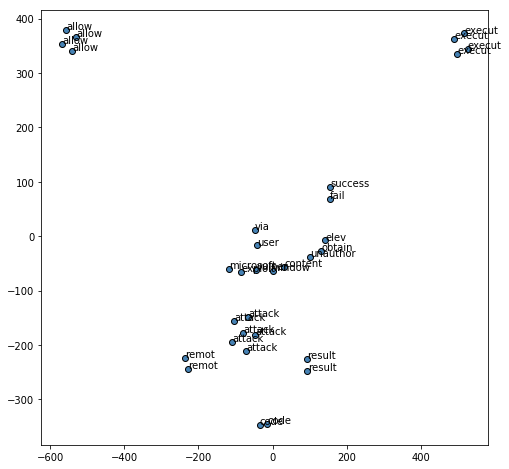

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

In [ ]:
#Generating Training Set
max_len_sentences = max([len(wpt.tokenize(doc)) for doc in norm_corpora]) #<------- [Parameter]
print("Max. Sentence # words:",max_len_sentences)

Max. Sentence # words: 367


In [ ]:
corpora_tensor = [[np.array(df_embedding_trans[word_]) for word_ in wpt.tokenize(doc) if word_ not in remove_terms] 
                  for doc in norm_corpora]

In [ ]:
len(wpt.tokenize(norm_corpora[0]))

15

In [ ]:
#BaseLine Architecture <-------
words_rows = max_len_sentences
embeddigs_cols = embed_size
input_sh = (words_rows,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 32 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [ ]:
input_sh

(367, 20, 1)

In [ ]:
#baseline_model = Sequential()
gram_input = Input(shape = input_sh)

In [ ]:
# 1st Convolutional Layer (1-gram)
conv_filter_1_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(1,embeddigs_cols), padding='valid',data_format="channels_last")(gram_input)

In [ ]:
conv_filter_1_gram

<tf.Tensor 'conv2d_18/Relu:0' shape=(None, 367, 1, 32) dtype=float32>

In [ ]:
# 2sd Convolutional Layer (3-gram)
conv_filter_3_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(3,embeddigs_cols), padding='valid')(gram_input)

In [ ]:
# 3rd Convolutional Layer (5-gram)
conv_filter_5_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(5,embeddigs_cols), padding='valid')(gram_input)

In [ ]:
# Max Pooling Layer
max_pool_1_gram = MaxPooling2D(pool_size=((words_rows-1+1), 1), strides=None, padding='valid')(conv_filter_1_gram)
max_pool_3_gram = MaxPooling2D(pool_size=((words_rows-3+1), 1), strides=None, padding='valid')(conv_filter_3_gram)
max_pool_5_gram = MaxPooling2D(pool_size=((words_rows-5+1), 1), strides=None, padding='valid')(conv_filter_5_gram)

In [ ]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_pool_1_gram)
fully_connected_3_gram = Flatten()(max_pool_3_gram)
fully_connected_5_gram = Flatten()(max_pool_5_gram)

In [ ]:
merged_vector = layers.concatenate([fully_connected_1_gram, fully_connected_3_gram, 
                                    fully_connected_5_gram], axis=-1)

integration_layer = Dropout(0.4)(merged_vector)

predictions = Dense(K, activation='softmax')(integration_layer)

In [ ]:
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [ ]:
criticality_network.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [ ]:
#Corpus Generation
import csv
import random